# Preâmbulo - instalando dependências

In [ ]:
!kaggle datasets download -d artermiloff/steam-games-dataset

Dataset URL: https://www.kaggle.com/datasets/artermiloff/steam-games-dataset
License(s): MIT
steam-games-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip steam-games-dataset.zip

Archive:  steam-games-dataset.zip
replace games_may2024_cleaned.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install subgroups

In [ ]:
!python3 -m pip install pysubgroup

In [ ]:
import pandas as pd
import numpy as np
import pysubgroup as ps
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, OneHotEncoder, MultiLabelBinarizer

# Explorando os dados

In [ ]:
data = pd.read_csv('games_may2024_cleaned.csv')
data.head(3)

,AppID,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.0,1,"For over two decades, Counter-Strike has offered an elite competitive experience, one shaped by millions of players from across the globe. And now the next chapter in the CS story is about to begin. This is Counter-Strike 2. A free upgrade to CS:GO, Counter-Strike 2 marks the largest technical leap in Counter-Strike’s history. Built on the Source 2 engine, Counter-Strike 2 is modernized with realistic physically-based rendering, state of the art networking, and upgraded Community Workshop tools. In addition to the classic objective-focused gameplay that Counter-Strike pioneered in 1999, Counter-Strike 2 features: All-new CS Ratings with the updated Premier mode Global and Regional leaderboards Upgraded and overhauled maps Game-changing dynamic smoke grenades Tick-rate-independent gameplay Redesigned visual effects and audio All items from CS:GO moving forward to CS2","For over two decades, Counter-Strike has offered an elite competitive experience, one shaped by millions of players from across the globe. And now the next chapter in the CS story is about to begin. This is Counter-Strike 2. A free upgrade to CS:GO, Counter-Strike 2 marks the largest technical leap in Counter-Strike’s history. Built on the Source 2 engine, Counter-Strike 2 is modernized with realistic physically-based rendering, state of the art networking, and upgraded Community Workshop tools. In addition to the classic objective-focused gameplay that Counter-Strike pioneered in 1999, Counter-Strike 2 features: All-new CS Ratings with the updated Premier mode Global and Regional leaderboards Upgraded and overhauled maps Game-changing dynamic smoke grenades Tick-rate-independent gameplay Redesigned visual effects and audio All items from CS:GO moving forward to CS2","For over two decades, Counter-Strike has offered an elite competitive experience, one shaped by millions of players from across the globe. And now the next chapter in the CS story is about to begin. This is Counter-Strike 2.",NaN,...,29018,753,6078,352,1362469,"{'FPS': 90076, 'Shooter': 64786, 'Multiplayer': 61798, 'Competitive': 52887, 'Action': 47165, 'Team-Based': 46061, 'e-sports': 43144, 'Tactical': 41033, 'First-Person': 39082, 'PvP': 34156, 'Online Co-Op': 33708, 'Co-op': 30037, 'Strategy': 29902, 'Military': 28512, 'War': 27826, 'Difficult': 25814, 'Trading': 25487, 'Realistic': 25261, 'Fast-Paced': 25188, 'Moddable': 6453}",87,8071426,80,56072
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.0,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS for free. Land on strategic locations, loot weapons and supplies, and survive to become the last team standing across various, diverse Battlegrounds. Squad up and join the Battlegrounds for the original Battle Royale experience that only PUBG: BATTLEGROUNDS can offer. This content download will also provide access to the BATTLEGROUNDS Test Server, which requires a separate download to play. Optional in-game purchases available.","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS for free. Land on strategic locations, loot weapons and supplies, and survive to become the last team standing across various, diverse Battlegrounds. Squad up and join the Battlegrounds for the original Battle Royale experience that only PUBG: BATTLEGROUNDS can offer. This content download will also provide access to the BATTLEGROUNDS Test Server, which requires a separate download to play. Optional in-game purchases available.","Play PUBG: BATTLEGROUNDS for free. Land on strategic locations, loot weapons and supplies, and survive to become the last team standing across various, diverse Battlegrounds. Squad up and join the Battlegrounds for the original B

In [ ]:
data.columns

Index(['AppID', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu', 'tags',
       'pct_pos_total', 'num_reviews_total', 'pct_pos_recent',
       'num_reviews_recent'],
      dtype='object')

## Sobre os dados
O conjunto de dados utilizados apresenta muitos domínios distintos. Algumas colunas de valores numéricos ou valores binários, como "price" (preço) ou "windows"/"mac"/"linux" (suporte a um sistema operacional específico) são fáceis de se interpretar e de se trabalhar.

Outras colunas, no entanto, devem ser melhoradas para que tragam alguma informação contemplável pelos algoritmos de aprendizado descritivo. Em alguns casos é útil determinar se um valor está presente, como "support_url" e "support_email". Em outros é útil determinar a extensão de uma coluna, como número de entradas em "supported_languages" ou "tags".


Em seguida foram criadas funções para se tratarem as colunas com tipos de dados mais complexos:

In [ ]:
def get_numeric_columns(data):
    return data.loc[:, ['required_age', 'price', 'average_playtime_forever', 'median_playtime_forever', 'num_reviews_total', 'peak_ccu', 'pct_pos_total', 'dlc_count', 'achievements']].astype(np.float32)


In [ ]:
def treat_json(x):
    treated_x = x.replace("'s","_s").replace("'em","_em").replace("'Em ", "_Em ").replace("'",'"')
    data = json.loads(treated_x)
    return data

def bool_to_num(x):
    return x.apply(float).astype(np.float32)

def exists_num(x):
    return (x > 0)

def exists_text(x):
    return (x!='').apply(float).astype(np.float32)

def flatten_sum(x):
    sum = 0
    try:
        data = treat_json(x)
        for (_,v) in data.items():
            sum += v
    finally:
        return np.float32(sum)
def _count_items(x):
    commas = x.count(',')
    if commas > 0:
        return commas+1
    else:
        return 0
def count_items(x):
    return x.apply(_count_items).astype(np.float32)

def remove_spaces_from_list(string_list):
    return [s.replace(" ", "") for s in string_list]

In [ ]:
def get_non_numeric_columns(data):
    adapted_data = data.copy()
    adapted_data[['supported_languages']] = adapted_data[['supported_languages']].apply(count_items, axis=0)
    adapted_data['tags'] = adapted_data['tags'].apply(flatten_sum)
    adapted_data[['categories']] = data[['categories']].apply(count_items, axis=0)
    adapted_data[['genres']] = data[['genres']].apply(count_items, axis=0)
    return adapted_data[['metacritic_score', 'windows', 'mac', 'linux', 'supported_languages', 'tags', 'categories', 'genres']]

# Aplicando algoritmos de aprendizado

## BeamSearch via biblioteca [pysubgroup](https://pysubgroup.readthedocs.io/en/latest/index.html)


Primeiro utilizamos a variável-alvo **metacritic_score** para a descoberta de subgrupos. Nem todos os jogos são avaliados pelo site, portanto tornamos a coluna em uma classificação binária entre "avaliado pelo Metacritic" e "não avaliado pelo Metacritic".

As colunas estudadas no resultado são:
- **subgroup**: contém a conjunção de regras que descreve o subgrupo
- **relative_size_sg**: contém o tamanho relativo do subgrupo (|subgrupo| / |dataset|)
- **coverage_sg**: Contém a porcentagem da variável-alvo de todo o dataset encontrada dentro do subgrupo
- **lift**: Proporção entre P(variável-alvo|subgrupo) e P(variável-alvo).

### Análise utilizando BeamSearch em relação ao metacritic_score

In [ ]:
df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
df['metacritic_score'] = df['metacritic_score'].apply(exists_num)

In [ ]:
target = ps.BinaryTarget('metacritic_score', True)
searchspace = ps.create_selectors(df, ignore=['metacritic_score'])
task = ps.SubgroupDiscoveryTask(
    df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

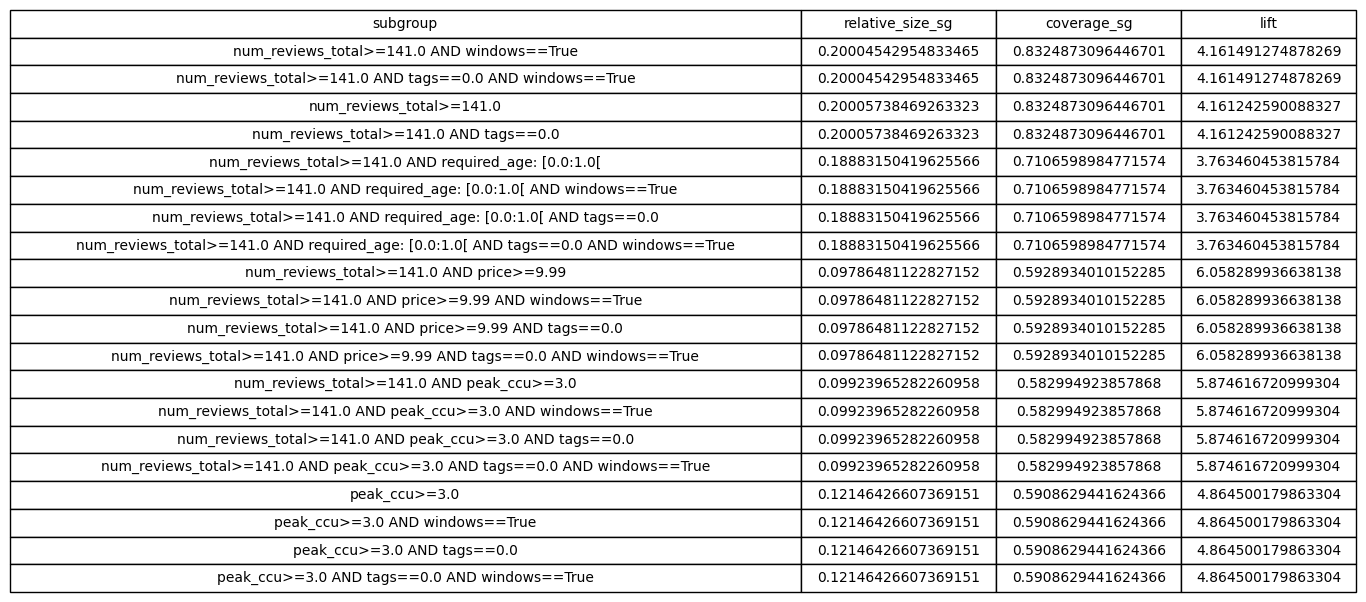

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/metacritic_beam.png', bbox_inches='tight', dpi=300)

plt.show()


Observamos que há uma grande concentração de jogos com no mínimo 141 avaliações por outros jogadores. É de se esperar que um jogo que tenha mais consumidores seja um jogo mais visível a um site de críticas e, portanto, passível de receber uma pontuação. No entanto, o patamar de 141 reviews é surpreendentemente baixo se considerarmos como os jogos são disponibilizados para todo um mercado mundial simultaneamente.

Adicionalmente, observa-se o subgrupo com maior Lift são jogos com mais de 141 reviews e preço igual ou superior a 10 dólares (subgrupo de índice 2). Trata-se de um dos subgrupos menos extensos encontrados, que no entanto contém 60% dos jogos avaliados pelo Metacritic. O resultado pode ser interpretado como a preferência pela plataforma de críticas a jogos com algum nível de comercialização, enquanto encontram-se na Steam diversos projetos experimentais com preços simbólicos ou nulos.

A principal observação é que a conjunção "AND windows=True" não altera em nada os resultados de cada subgrupo. É esperado: trata-se do sistema operacional dominante dentro da indústria de jogos, e virtualmente não há lançamento que exclua essa plataforma.

A adição das colunas não-numéricas dessa forma não impactou os resultados, e continuamos com o mesmo insight sobre os dados.

### Análise das características dos subgrupos com os maiores valores do atributo metacritic_score

In [ ]:
pd.set_option('display.max_colwidth', None)
ms_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
(ms_df['metacritic_score'] == 0).sum()
ms_df = ms_df.query('metacritic_score > 0')
ms_df['metacritic_score'].describe()

,metacritic_score
count,3940.000000
mean,73.266244
std,10.388221
min,20.000000
25%,68.000000
50%,75.000000
75%,80.000000
max,97.000000


In [ ]:
ms_df['metacritic_score'] = ms_df['metacritic_score'].apply(lambda x: x>80)

In [ ]:
target = ps.BinaryTarget('metacritic_score', True)
searchspace = ps.create_selectors(ms_df, ignore=['metacritic_score'])
task = ps.SubgroupDiscoveryTask(
    ms_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

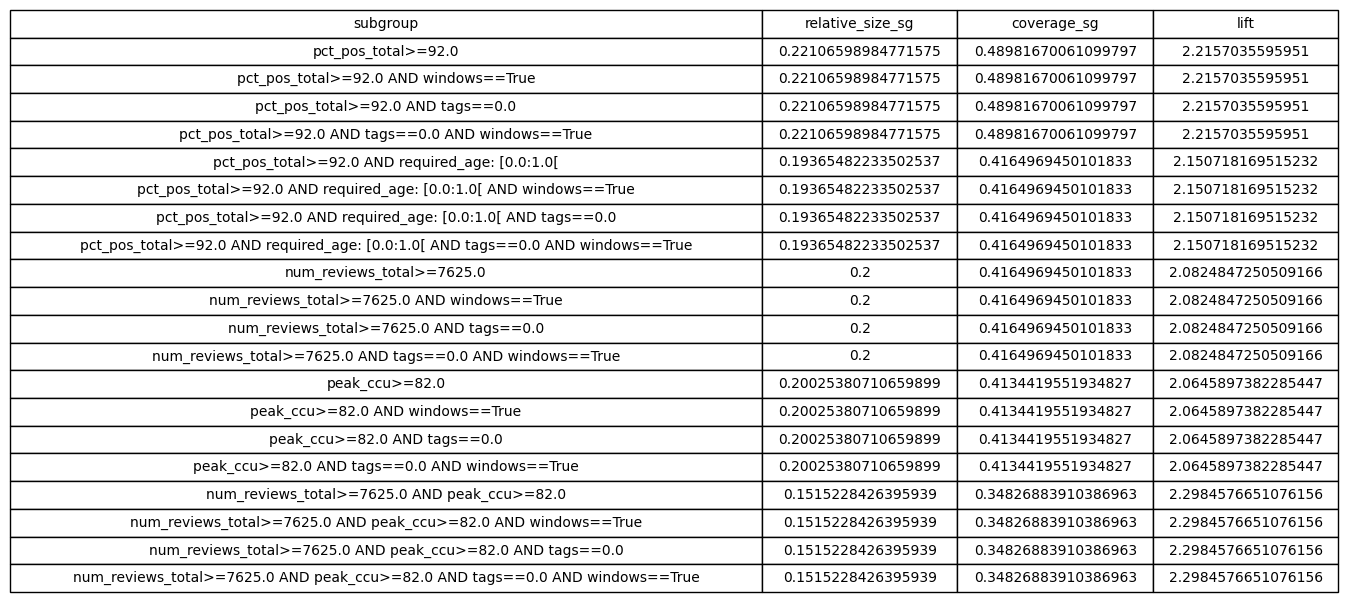

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/metacritic_maior.png', bbox_inches='tight', dpi=300)

plt.show()

### Análise das características dos subgrupos com os menores valores do atributo metacritic_score

In [ ]:
pd.set_option('display.max_colwidth', None)
ms_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
(ms_df['metacritic_score'] == 0).sum()
ms_df = ms_df.query('metacritic_score > 0')

In [ ]:
ms_df['metacritic_score'] = ms_df['metacritic_score'].apply(lambda x: x<=80)

In [ ]:
target = ps.BinaryTarget('metacritic_score', True)
searchspace = ps.create_selectors(ms_df, ignore=['metacritic_score'])
task = ps.SubgroupDiscoveryTask(
    ms_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

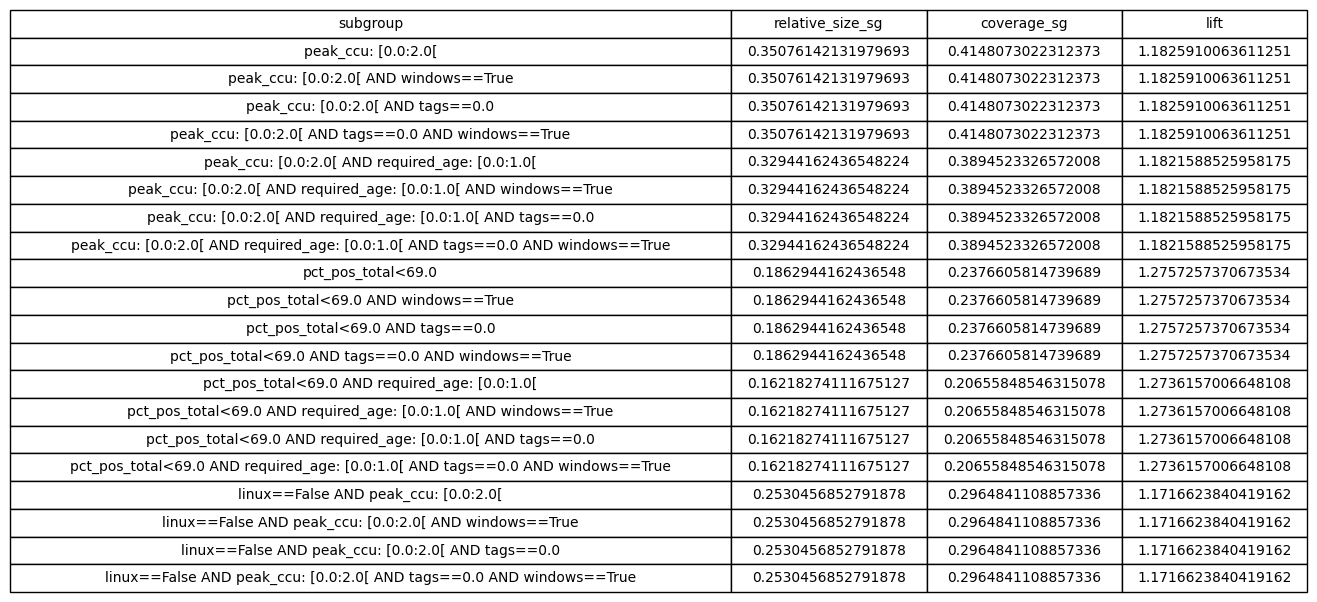

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/metacritic_menor.png', bbox_inches='tight', dpi=300)

plt.show()

### Avaliação das características dos subgrupos de jogos com preço alto

In [ ]:
data['price'].describe()

,price
count,83646.000000
mean,7.492446
std,13.094604
min,0.000000
25%,0.990000
50%,4.990000
75%,9.990000
max,999.980000


In [ ]:
price_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
# price_df['price_bin'] = price_df['price']>7.49

# Preço foi definido como maior que o preço médio dos jogos que é igual a 59
price_df['price_bin'] = price_df['price'] > 59
price_df = price_df.query('num_reviews_total > 0')
price_df = price_df.query('peak_ccu > 0')
price_df = price_df.query('average_playtime_forever > 0')
price_df = price_df.query('metacritic_score > 0')

price_df = price_df.drop('price', axis=1)

In [ ]:
target = ps.BinaryTarget('price_bin', True)
searchspace = ps.create_selectors(price_df, ignore=['price_bin', 'median_playtime_forever'])
task = ps.SubgroupDiscoveryTask(
    price_df,
    target,
    searchspace,
    result_set_size=20,
    depth=20,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

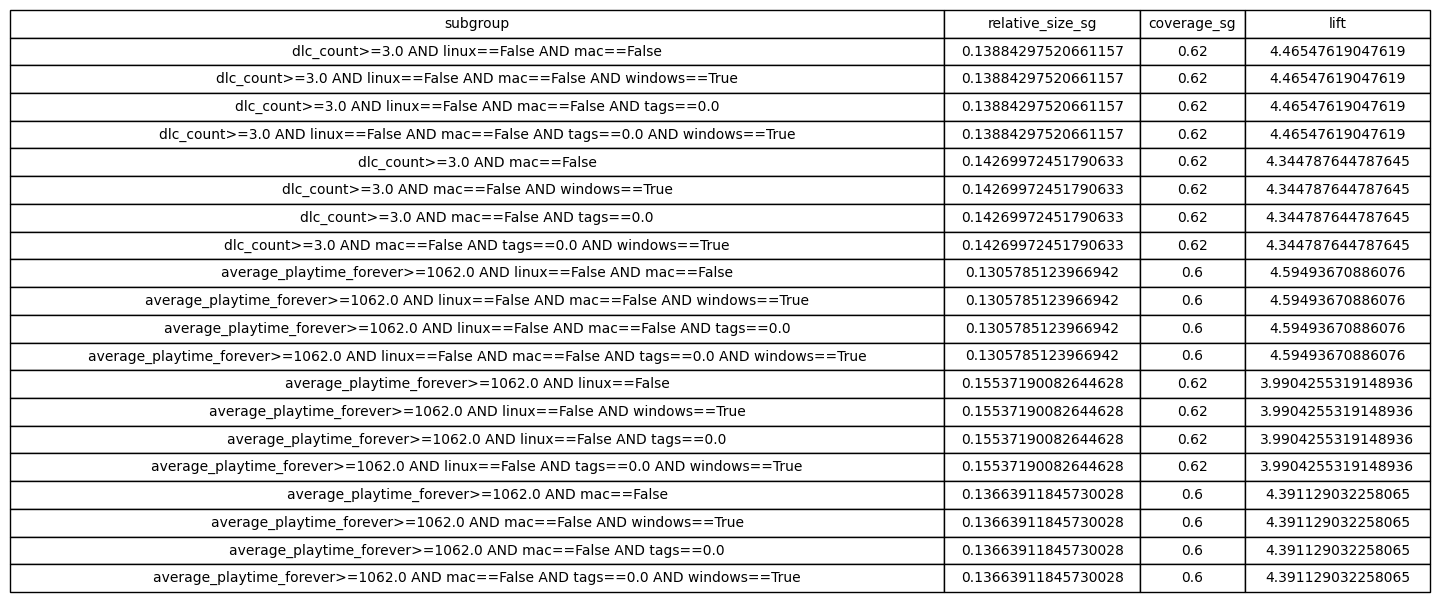

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/preco_alto.png', bbox_inches='tight', dpi=300)

plt.show()

### Avaliação das características dos subgrupos de jogos com preço baixo

In [ ]:
price_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
price_df['price_bin'] = price_df['price'] <= 7.49
price_df = price_df.drop('price', axis=1)

In [ ]:
target = ps.BinaryTarget('price_bin', True)
searchspace = ps.create_selectors(price_df, ignore=['price_bin'])
task = ps.SubgroupDiscoveryTask(
    price_df,
    target,
    searchspace,
    result_set_size=5,
    depth=20,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

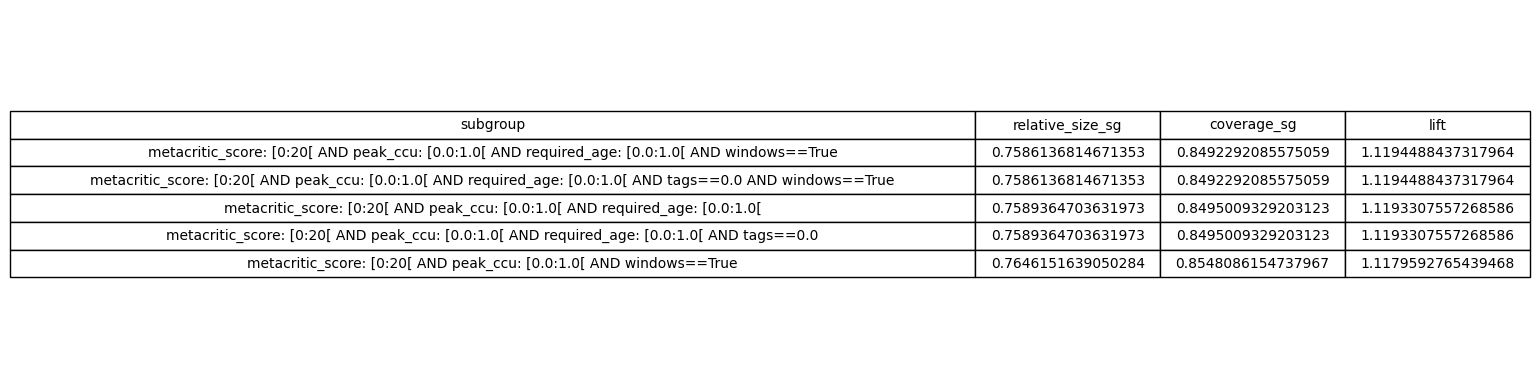

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/preco_baixo.png', bbox_inches='tight', dpi=300)

plt.show()

### Análise das características dos subgrupos para idades recomendadas maiores

In [ ]:
age_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
age_df['required_age'] = age_df['required_age'].apply(lambda x: x > 16)

In [ ]:
target = ps.BinaryTarget('required_age', True)
searchspace = ps.create_selectors(age_df, ignore=['required_age'])
task = ps.SubgroupDiscoveryTask(
    age_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

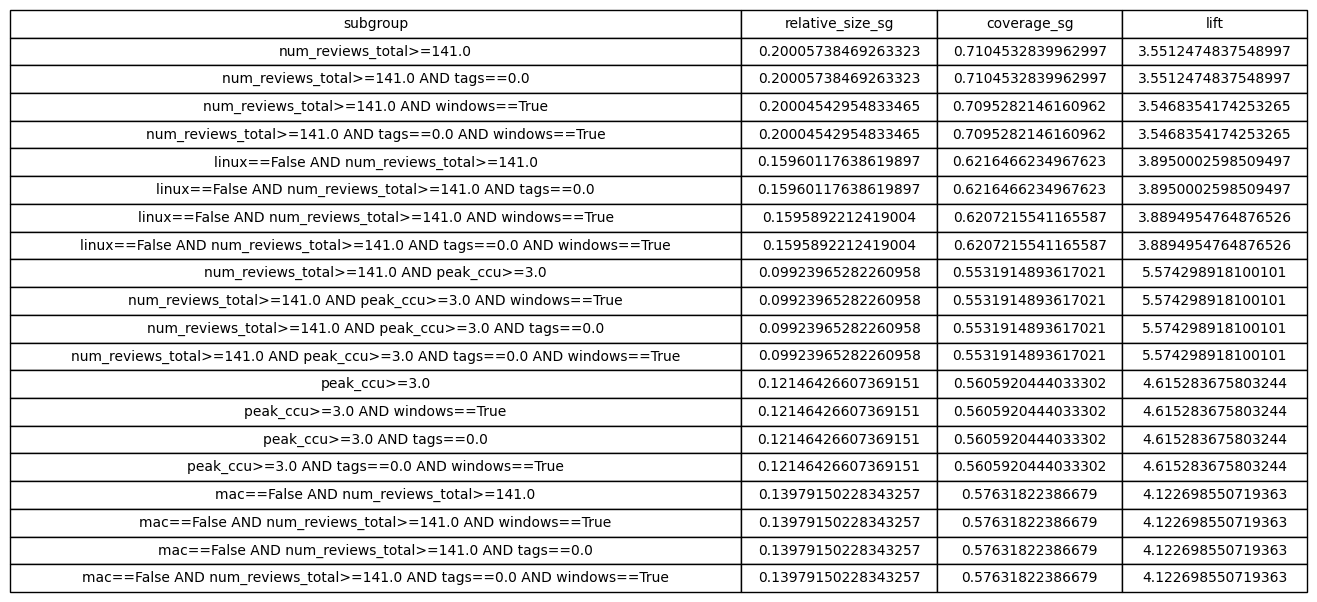

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/idade_maior.png', bbox_inches='tight', dpi=300)

plt.show()

### Análise das características dos subgrupos para idades recomendadas menores

In [ ]:
age_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)
age_df['required_age'] = age_df['required_age'].apply(lambda x: x <= 16)

In [ ]:
target = ps.BinaryTarget('required_age', True)
searchspace = ps.create_selectors(age_df, ignore=['required_age', 'median_playtime_forever', 'windows'])
task = ps.SubgroupDiscoveryTask(
    age_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

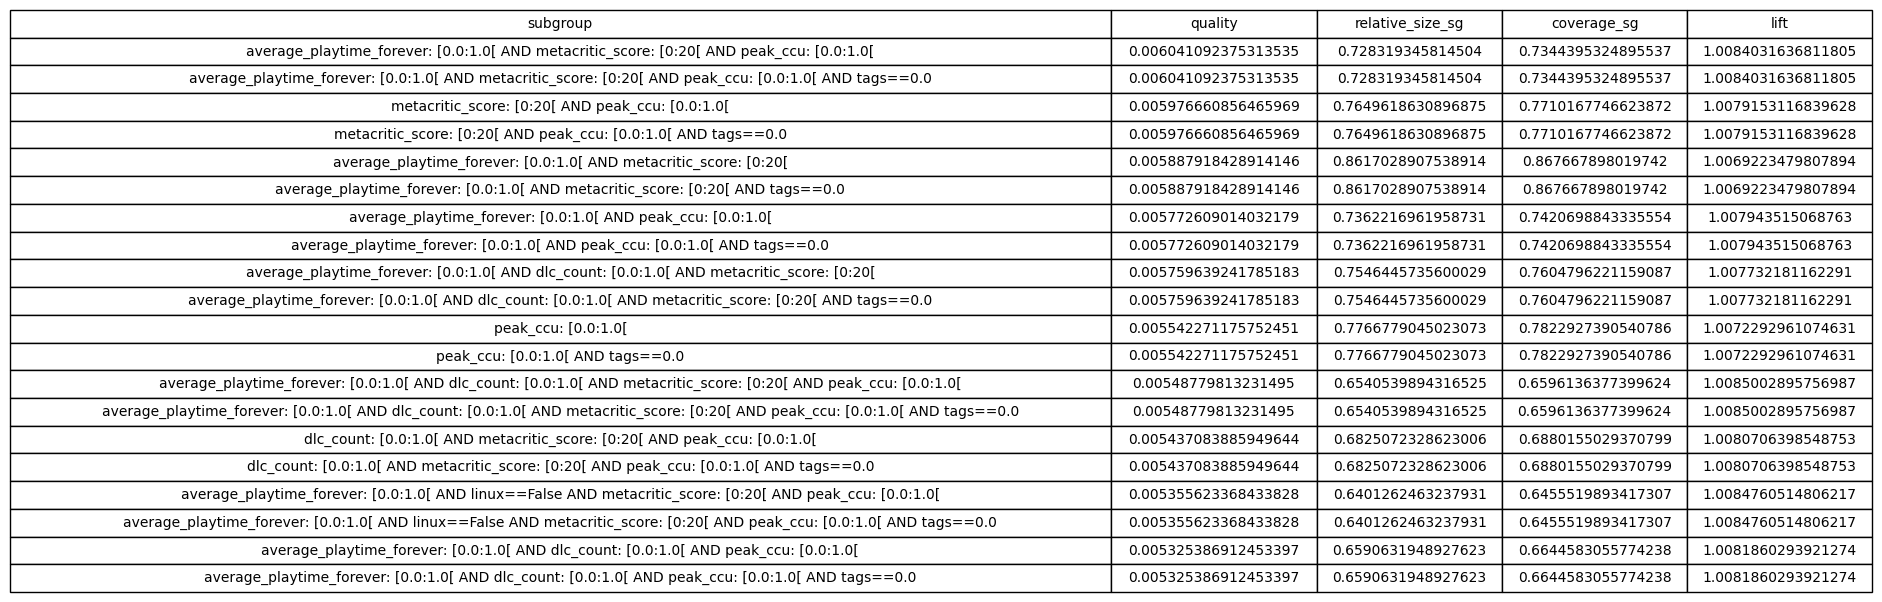

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'quality', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/idade_menor.png', bbox_inches='tight', dpi=300)

plt.show()

### Analise sistemas operacionais

In [ ]:
so_df = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)

In [ ]:
target = ps.BinaryTarget('mac', True)
searchspace = ps.create_selectors(so_df, ignore=['mac', 'required_age', 'linux', 'windows'])
task = ps.SubgroupDiscoveryTask(
    so_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

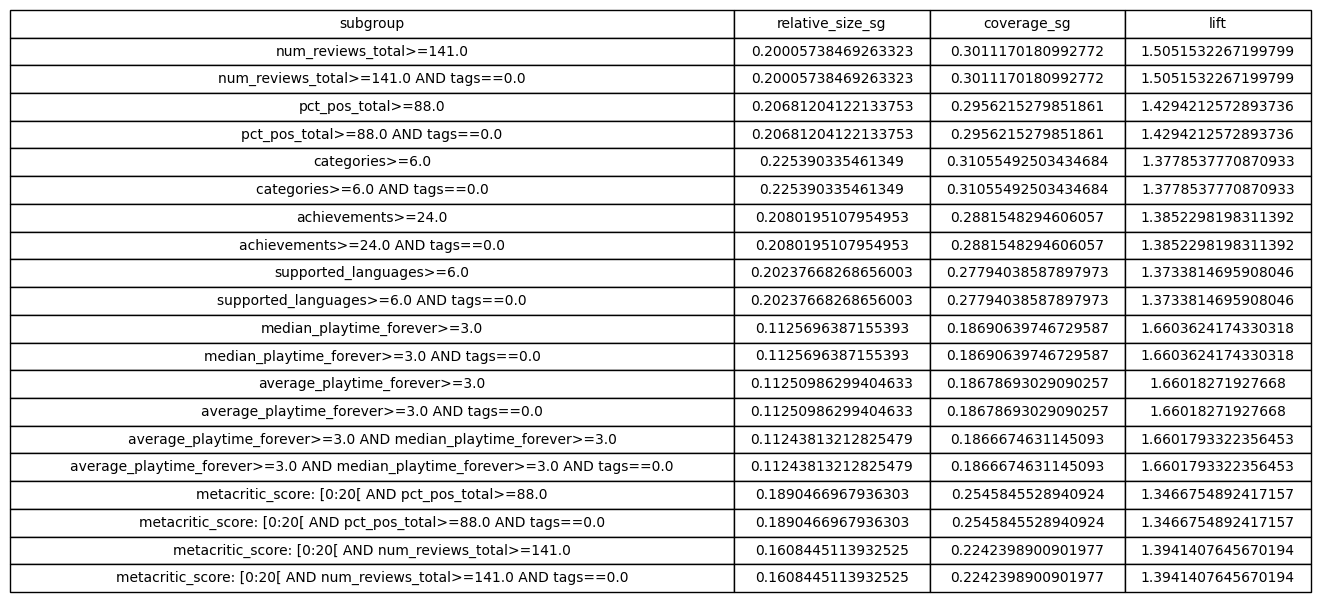

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/mac.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
target = ps.BinaryTarget('linux', True)
searchspace = ps.create_selectors(so_df, ignore=['mac', 'required_age', 'linux', 'windows'])
task = ps.SubgroupDiscoveryTask(
    so_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

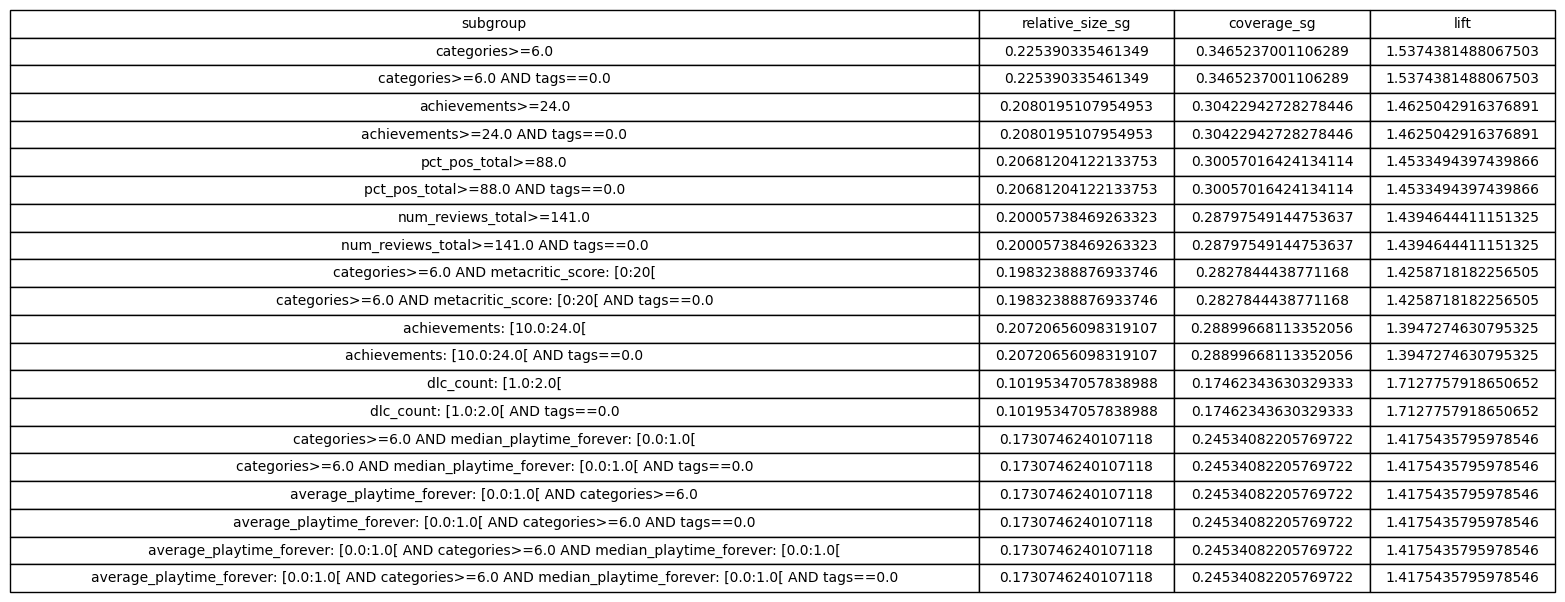

In [ ]:
result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/linux.png', bbox_inches='tight', dpi=300)

plt.show()

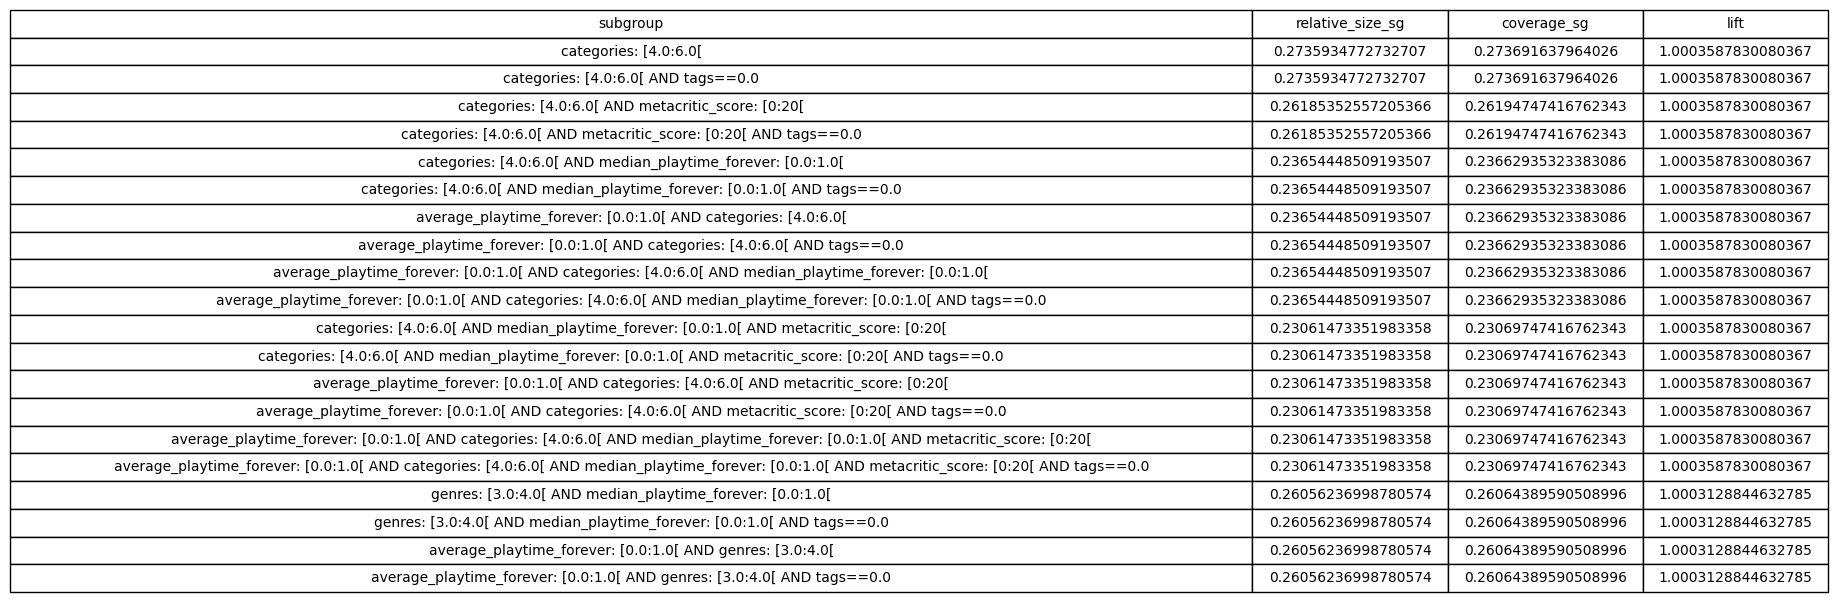

In [ ]:
target = ps.BinaryTarget('windows', True)
searchspace = ps.create_selectors(so_df, ignore=['mac', 'required_age', 'linux', 'windows'])
task = ps.SubgroupDiscoveryTask(
    so_df,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

result_df = result.to_dataframe()[['subgroup', 'relative_size_sg', 'coverage_sg', 'lift']]

fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(result_df.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.075)

plt.savefig('img/windows.png', bbox_inches='tight', dpi=300)

plt.show()

## SDMap via biblioteca [subgroups](https://pypi.org/project/subgroups/)

### Pré processamento

In [ ]:
dataset = pd.concat([get_numeric_columns(data), get_non_numeric_columns(data)], axis=1)

In [ ]:
def preprocessamento_var_bin(data, columns):
  df = pd.DataFrame()
  for c in columns:
    label_encoder = LabelEncoder()
    df[c] = label_encoder.fit_transform(data[c])

  return df

In [ ]:
def preprocessamento_var_num(data, columns):
    df = pd.DataFrame(index=data.index)  # Mantém o mesmo índice do DataFrame original
    for c in columns:
        discretizer = KBinsDiscretizer(n_bins=3, strategy='uniform', encode='ordinal')
        df[c] = discretizer.fit_transform(data[[c]].values.reshape(-1, 1))  # Transforma para o formato inteiro
    return df

In [ ]:
df = pd.DataFrame()

df = pd.concat([df, preprocessamento_var_bin(dataset, ['windows', 'mac', 'linux'])], axis=1)

In [ ]:
df = pd.concat([df, preprocessamento_var_num(dataset, ['metacritic_score', 'supported_languages', 'tags', 'categories', 'genres', 'required_age', 'price', 'average_playtime_forever', 'median_playtime_forever', 'num_reviews_total', 'peak_ccu', 'pct_pos_total', 'dlc_count', 'achievements'])], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:2

### Análise utilizando o SDMap em relação ao metacritic_score

In [ ]:
df_ms = df.copy()
df_ms['metacritic_score'] = dataset['metacritic_score'].apply(exists_num)

In [ ]:
from subgroups.quality_measures import WRAcc
from subgroups.algorithms import SDMap

target = ('metacritic_score', 1)
df_ms = df_ms.astype(str)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_ms.txt")
SDMap.selected_subgroups = 10
model.fit(df_ms, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_ms.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = 

### Análise das caracteristicas dos subgrupos com os maiores valores do atributo metacritic_score

In [ ]:
df_ms = df.copy()

In [ ]:
df_ms['metacritic_score'] = dataset['metacritic_score']>80

In [ ]:
df_ms = df_ms.astype(str)
target = ('metacritic_score', 1)


model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_ms_ac_mean.txt")
SDMap.selected_subgroups = 10
model.fit(df_ms, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_ms_ac_mean.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = 

### Análise das caracteristicas dos subgrupos com os menores valores do atributo metacritic_score

In [ ]:
df_ms = df.copy()
df_ms['metacritic_score'] =  (dataset['metacritic_score'] != 0) & (dataset['metacritic_score'] <= 80)

In [ ]:
df_ms = df_ms.astype(str)
target = ('metacritic_score', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_ab_mean.txt")
SDMap.selected_subgroups = 10
model.fit(df_ms, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_ab_mean.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: metacritic_score = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = 

### Análise das características dos subgrupos de jogos com preço alto

In [ ]:
price_df = df.copy()
price_df['price'] = dataset['price']>7.49

In [ ]:
price_df = price_df.astype(str)
target = ('price', 1)


model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_price_ac_mean.txt")
SDMap.selected_subgroups = 10
model.fit(price_df, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_price_ac_mean.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: pr

### Análise características subgrupos com preço baixo

In [ ]:
price_df = df.copy()
price_df['price'] = dataset['price']<=7.49

In [ ]:
price_df = price_df.astype(str)
target = ('price', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_price_ab_mean.txt")
SDMap.selected_subgroups = 10
model.fit(price_df, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_price_ab_mean.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: price = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: pr

### Análise caracteristicas dos subgrupos com alto número de reviews




In [ ]:
reviews_df = df.copy()
reviews_df['num_reviews_total'] = (dataset['num_reviews_total']!= -1) & (dataset['num_reviews_total'] <= 2.237123e+03)

In [ ]:
reviews_df = reviews_df.astype(str)
target = ('num_reviews_total', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_review_ab_mean.txt")
SDMap.selected_subgroups = 10
model.fit(reviews_df, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_review_ab_mean.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [pct_pos_total = '2.0', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', pct_pos_total = '2.0', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', pct_pos_total = '2.0', peak_ccu = '2.0'], T

### Análise caracteristicas dos subgrupos com baixo número de reviews


In [ ]:
reviews_df = df.copy()
reviews_df['num_reviews_total'] = (dataset['num_reviews_total']!= -1) & (dataset['num_reviews_total'] > 2.237123e+03)

In [ ]:
reviews_df = reviews_df.astype(str)
target = ('num_reviews_total', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_review_ac_mean.txt")
SDMap.selected_subgroups = 10
model.fit(reviews_df, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_review_ac_mean.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [pct_pos_total = '2.0', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', pct_pos_total = '2.0', peak_ccu = '2.0'], Target: num_reviews_total = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', pct_pos_total = '2.0', peak_ccu = '2.0'], T

### Análise características dos subgrupos para idades recomendadas menores

In [ ]:
age_df = df.copy()
age_df['required_age'] = dataset['required_age'] <=16

In [ ]:
age_df = age_df.astype(str)
target = ('required_age', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_age_ab.txt")
SDMap.selected_subgroups = 10
model.fit(age_df, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_age_ab.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total =

### Análise características dos subgrupos para idades recomendadas maiores

In [ ]:
age_df = df.copy()
age_df['required_age'] = dataset['required_age'] > 16

In [ ]:
age_df = age_df.astype(str)
target = ('required_age', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_age_ac.txt")
SDMap.selected_subgroups = 10
model.fit(age_df, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_age_ac.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: required_age = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total =

### Análise sistemas operacionais

In [ ]:
df_so = df.copy()
df_so = df_so.astype(str)
target = ('windows', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_windows.txt")
SDMap.selected_subgroups = 10
model.fit(df_so, target)

In [ ]:
subgroups_to_read = 10
  with open("./sdmap_results_windows.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: windows = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: windows = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: windows = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: windows = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: windows = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: windows = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0', pct_pos_total = '2.0']

In [ ]:
df_so = df.copy()
df_so = df_so.astype(str)
target = ('linux', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_linux.txt")
SDMap.selected_subgroups = 10
model.fit(df_so, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_linux.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: linux = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: linux = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: linux = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: linux = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [mac = '0', num_reviews_total = '2.0'], Target: linux = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', mac = '0', num_reviews_total = '2.0'], Target: linux = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [mac = '0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: linux = 

In [ ]:
df_so = df.copy()
df_so = df_so.astype(str)
target = ('mac', 1)

model = SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = -1, minimum_n = 0, write_results_in_file = True, file_path = "./sdmap_results_mac.txt")
SDMap.selected_subgroups = 10
model.fit(df_so, target)

In [ ]:
subgroups_to_read = 10
with open("./sdmap_results_mac.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [num_reviews_total = '2.0'], Target: mac = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0'], Target: mac = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0'], Target: mac = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', linux = '1', num_reviews_total = '2.0'], Target: mac = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: mac = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [categories = '1.0', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: mac = 1 ; Quality Measure WRAcc = 0.0 ; tp = 0 ; fp = 1 ; TP = 0 ; FP = 83646
Description: [linux = '1', num_reviews_total = '2.0', pct_pos_total = '2.0'], Target: mac = 1 ; Qual